## author: Keer Mei
- github: kmei92
- email: keer.mei18@imperial.ac.uk

# Setup

In [1]:
# importing the necessary modules
import sys
sys.path.append("..")
from PDESystem import *
from PDESubsystem import *
from pdeforms import *

%load_ext autoreload
%autoreload 2

In [26]:
# a PDESystem child class called PDESolver. Note, the setup_constants function and setup_bcs are declared
# and overloaded here and the PDESystem's functions are not used. This is designed for clarity
class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        
        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (1, 4)), # top-bottom and cylinder
            fd.DirichletBC(self.V['u'], ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 3)]  # outflow

#         bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (10, 12)), # top-bottom
#           fd.DirichletBC(self.V['u'], ((1.0*(y - 1)*(2 - y))/(0.5**2) ,0), 9)] # inflow
#         bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 11)]  # outflow

#         bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (10, 12))] # no slip top-bottom
#         bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 11), #outflow
#                 fd.DirichletBC(self.V['p'], fd.Constant(8), 9)]  # inlet pressure

        self.bc['u'][0] = [bcu, None, None, None,'fixed']
        self.bc['p'] = [[bcp, None, None, None, 'fixed']]

    def setup_constants(self):
        x, y = fd.SpatialCoordinate(self.mesh)
#         self.constants = {
#             'k' : fd.Constant(self.prm['dt']),
#             'Kd' : fd.Constant(0.001),
#             'k1' : fd.Constant(0.01),
#             'k2' : fd.Constant(0.005),
#             'lamd1' : fd.Constant(0.000025),
#             'lamd2' : fd.Constant(0.00025),
#             'rho_s' : fd.Constant(1.),
#             'L' :  fd.Constant(1.),
#             'phi' : fd.Constant(0.3),
#             'f' : fd.Constant(1.),
#             'n' : fd.FacetNormal(self.mesh),
#             'f' : fd.Constant((0.0, 0.0)),
#             'nu' : fd.Constant(0.001),
#             'frac' : fd.Constant(1.),
#             'source1' : fd.conditional(pow(x-1, 2)+pow(y-1.5,2)<0.25*0.25, 10, 0)
#         }
        self.constants = {
            'k' : fd.Constant(self.prm['dt']),
            'Kd' : fd.Constant(0.0),
            'k1' : fd.Constant(0.0),
            'k2' : fd.Constant(0.0),
            'lamd1' : fd.Constant(0.0),
            'lamd2' : fd.Constant(0.0),
            'rho_s' : fd.Constant(1.),
            'L' :  fd.Constant(1.),
            'phi' : fd.Constant(0.3),
            'f' : fd.Constant(1.),
            'n' : fd.FacetNormal(self.mesh),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'frac' : fd.Constant(1.),
            'source1' : fd.conditional(pow(x-0.1, 2)+pow(y-0.1,2)<0.05*0.05, 10.0, 0)
        }
        

# Solve

In [44]:
# update the parameters
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'c': fd.MixedFunctionSpace},
'degree': {'u': 2},
'order' : {'u': 1, 'p': 1, 'c':3},
'ksp_type': {'u': 'gmres', 'p': 'gmres',  'c': 'gmres'},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : 0.00005,
'T' : 0.1}
)

#load mesh
mesh = fd.Mesh("../../meshes/highres_cylinder.msh")

# add subsystems for navier stokes and radio_transport
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)

#setup constants
solver.setup_constants()

# define subsystems and variable sequence
solver.define(['u', 'p', 'u'], 'up', navier_stokes)
solver.define(['cd', 'cs', 'as'], 'cdcsas', radio_transport)

# setup boundary conditions
solver.setup_bcs()

# # #setup initial condition for the first species in the dissolved phase
# x, y = fd.SpatialCoordinate(mesh)
# c = fd.conditional(pow(x-1, 2)+pow(y-1.5,2)<0.25*0.25, 10, 0)
# solver.setup_initial('cd_n', c, mixedspace=True, index=0)

#solve
solver.solve()

# Plotting

## Pressure and Velocity

(-0.11000000000000001, 2.31, -0.0205, 0.4305)

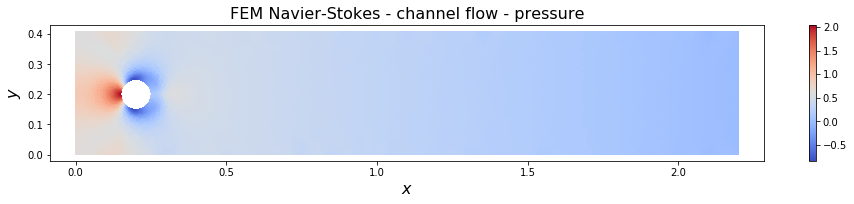

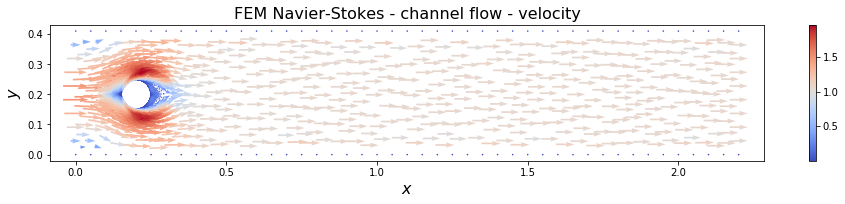

In [45]:
fig1 = plt.figure(figsize=(16, 2.5))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
fd.plot(solver.form_args['p_'],axes=ax1)
ax1.axis('equal')

fig2 = plt.figure(figsize=(16, 2.5))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(solver.form_args['u_'],axes=ax2)
ax2.axis('equal')

## Dissolved Phase

(-0.11000000000000006,
 2.310000000000001,
 -0.020500000000000004,
 0.43050000000000005)

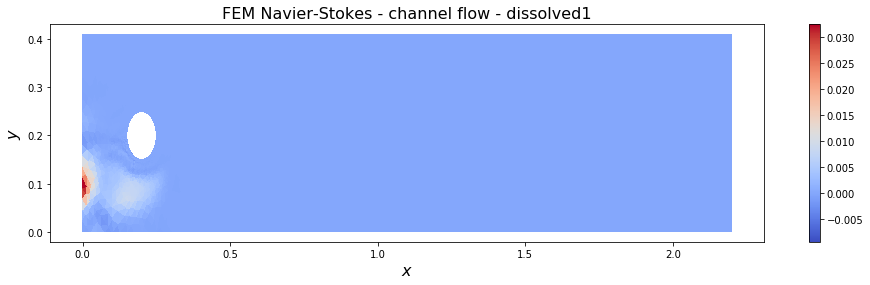

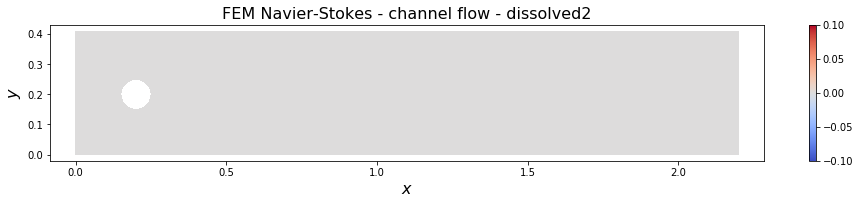

In [50]:
# since each phase contains two species and is a MixedFunctionSpace, use firedrake's split function
# to retrieve each subcomponent
cd1, cd2 = solver.form_args['cd_n'].split()

fig3 = plt.figure(figsize=(16, 4))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - dissolved1', fontsize=16)
fd.plot(cd1,axes=ax3)
# ax3.axis('equal')

fig4 = plt.figure(figsize=(16, 2.5))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('FEM Navier-Stokes - channel flow - dissolved2', fontsize=16)
fd.plot(cd2, axes=ax4)
ax4.axis('equal')

## Suspended Phase

(-0.11000000000000006,
 2.310000000000001,
 -0.020500000000000004,
 0.43050000000000005)

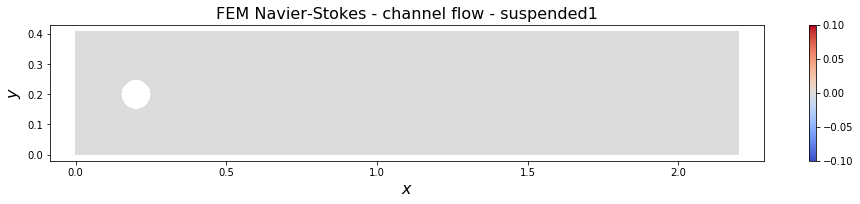

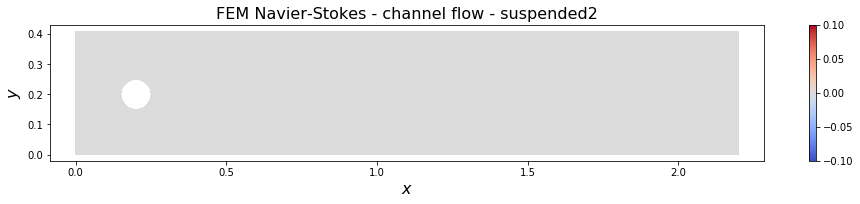

In [36]:
# since each phase contains two species and is a MixedFunctionSpace, use firedrake's split function
# to retrieve each subcomponent
cs1, cs2 = solver.form_args['cs_'].split()

fig5 = plt.figure(figsize=(16, 2.5))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('FEM Navier-Stokes - channel flow - suspended1', fontsize=16)
fd.plot(cs1, axes=ax5)
ax5.axis('equal')

fig6 = plt.figure(figsize=(16, 2.5))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('FEM Navier-Stokes - channel flow - suspended2', fontsize=16)
fd.plot(cs2, axes=ax6)
ax6.axis('equal')

## Sediment Phase

(-0.11000000000000006,
 2.310000000000001,
 -0.020500000000000004,
 0.43050000000000005)

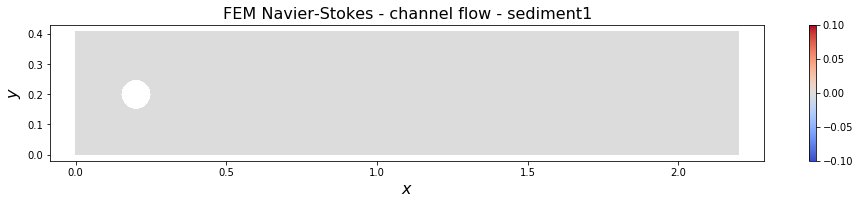

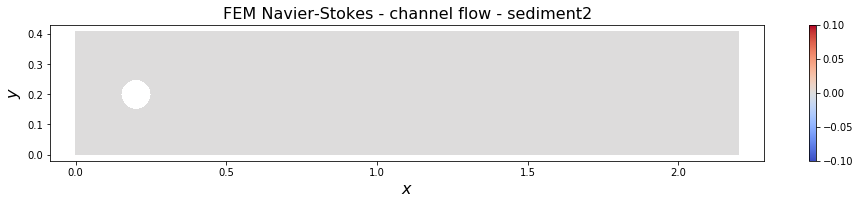

In [37]:
# since each phase contains two species and is a MixedFunctionSpace, use firedrake's split function
# to retrieve each subcomponent
as1, as2 = solver.form_args['as_'].split()

fig7 = plt.figure(figsize=(16, 2.5))
ax7 = fig7.add_subplot(111)
ax7.set_xlabel('$x$', fontsize=16)
ax7.set_ylabel('$y$', fontsize=16)
ax7.set_title('FEM Navier-Stokes - channel flow - sediment1', fontsize=16)
fd.plot(as1, axes=ax7)
ax7.axis('equal')

fig8 = plt.figure(figsize=(16, 2.5))
ax8 = fig8.add_subplot(111)
ax8.set_xlabel('$x$', fontsize=16)
ax8.set_ylabel('$y$', fontsize=16)
ax8.set_title('FEM Navier-Stokes - channel flow - sediment2', fontsize=16)
fd.plot(as2, axes=ax8)
ax8.axis('equal')